# Stock Price Prediction with News

### Breif Overview:

There are two datasets

1. Stock Prices Dataset for {"复星医药", "恒瑞医药", "沃森生物"}
2. news dataset

Steps:

1. Data Preparation
2. Data Visualization
3. Training
4. Testing

### import package

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from numpy.random import seed
import tensorflow as tf
import csv
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from pandas import Series, datetime
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  # Remove the CWD from sys.path while we load stuff.


### initianize random

In [2]:
np.random.seed(123)
random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.random.set_seed(1234)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)
seed(1)

### set parameters
stock_name in {"复星医药", "恒瑞医药", "沃森生物"}
news_method in {0, 1, 2}, where 0:t-1; 1:t; 2:none. 

In [3]:
stock_name = "复星医药"
news_name = stock_name + "_总"
news_method = 2
inner_merge = False
sns.set()

## 1. Data Preparation:

### Step0: preparation

In [4]:
stock_data = "./data/" + stock_name + ".csv"
news_data = "./output/" + news_name + "_my_out.csv"

In [5]:
csv.field_size_limit(500 * 1024 * 1024)
with open(stock_data) as f:
    reader = csv.reader(f)
    stock_rows = [row for row in reader]
with open(news_data) as f:
    reader = csv.reader(f)
    news_rows = [row for row in reader]
j = 1
i = 1

def compare_data(first, second):
    a = int(first[:4] + first[5:7] + first[-2:])
    b = int(second[:4] + second[5:7] + second[-2:])
    if a > b:
        return 1
    if a == b:
        return 2
    if a < b:
        return 3
    
while i < len(news_rows) and j < len(stock_rows):
    compare_res = compare_data(news_rows[i][0], stock_rows[j][0])
    if compare_res == 1:
        add_rows = [stock_rows[j][0], news_rows[i][1], news_rows[i][2]]
        news_rows.insert(i, add_rows)
    elif compare_res == 3:
        i += 1
    elif compare_res == 2:
        j += 1
        i += 1


date, poscount_list, negcount_list = [], [], []
for i in range(1, len(news_rows)):
    date.append(news_rows[i][0])
    poscount_list.append(float(news_rows[i][1]))
    negcount_list.append(float(news_rows[i][2]))
    
news_data = "./output/" + news_name + "_my_out_1.csv"
ff = open(news_data,'w',encoding='utf-8')
# 2. 基于文件对象构建 csv写入对象
csv_writer = csv.writer(ff)
# 3. 构建列表头
csv_writer.writerow(["date","pos","neg"])
for i in range(1, len(news_rows)):
    csv_writer.writerow([format(date[i-1]),format(poscount_list[i-1]),format(negcount_list[i-1])])
ff.close()
if inner_merge == True:
    news_data = "./output/" + news_name + "_my_out.csv"

### Step1: load stock price data

In [6]:
stock_data = pd.read_csv(stock_data, parse_dates=[0])
stock_data.columns = ['date', 'open', 'close', 'high', 'low', 'volume', 'money']
stock_data.head()

,date,open,close,high,low,volume,money
0,2020-05-25,30.91,31.12,31.52,30.78,20599861.0,6.412297e+08
1,2020-05-26,31.33,31.33,31.66,31.16,18963313.0,5.943644e+08
2,2020-05-27,31.37,30.80,31.47,30.37,27555024.0,8.486539e+08
3,2020-05-28,30.68,30.11,31.03,29.75,30655938.0,9.267066e+08
4,2020-05-29,30.15,30.54,30.74,30.12,23890232.0,7.284473e+08


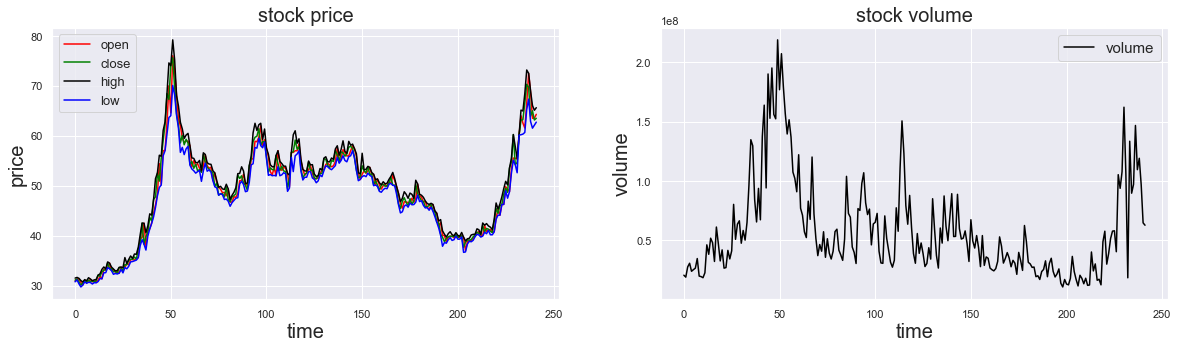

In [7]:
plt.figure(figsize=(20, 5));
plt.subplot(1,2,1);
plt.plot(stock_data['open'].values, color='red', label='open')
plt.plot(stock_data['close'].values, color='green', label='close')
plt.plot(stock_data['high'].values, color='black', label='high')
plt.plot(stock_data['low'].values, color='blue', label='low')
plt.title('stock price', fontsize=20)
plt.xlabel('time', fontsize=20)
plt.ylabel('price', fontsize=20)
plt.legend(loc='best', fontsize=13)

plt.subplot(1,2,2);
plt.plot(stock_data['volume'].values, color='black', label='volume')
plt.title('stock volume', fontsize=20)
plt.xlabel('time', fontsize=20)
plt.ylabel('volume', fontsize=20)
plt.legend(loc='best', fontsize=15);

### Step2: load news data

In [8]:
news_data = pd.read_csv(news_data)
news_data['date'] = pd.to_datetime(news_data['date'])
print(news_data.shape)
print(news_data.head())

(496, 3)
        date       pos       neg
0 2020-01-01  1.411908  0.624974
1 2020-01-02  7.526965  0.901576
2 2020-01-03  5.148129  0.311636
3 2020-01-04  0.018156  0.174528
4 2020-01-05  0.207329  0.207329


In [9]:
print(stock_data.head())
print(stock_data.shape)

        date   open  close   high    low      volume         money
0 2020-05-25  30.91  31.12  31.52  30.78  20599861.0  6.412297e+08
1 2020-05-26  31.33  31.33  31.66  31.16  18963313.0  5.943644e+08
2 2020-05-27  31.37  30.80  31.47  30.37  27555024.0  8.486539e+08
3 2020-05-28  30.68  30.11  31.03  29.75  30655938.0  9.267066e+08
4 2020-05-29  30.15  30.54  30.74  30.12  23890232.0  7.284473e+08
(242, 7)


### Step3: 情感分析&新闻数据结合

In [10]:
merged_data = stock_data
merged_data = news_data[['date', 'pos', 'neg']].merge(stock_data, how='inner', on='date')
print(merged_data.shape)
merged_data.head()

(242, 9)


,date,pos,neg,open,close,high,low,volume,money
0,2020-05-25,0.451054,0.025495,30.91,31.12,31.52,30.78,20599861.0,6.412297e+08
1,2020-05-26,0.052651,0.193771,31.33,31.33,31.66,31.16,18963313.0,5.943644e+08
2,2020-05-27,0.239771,0.046422,31.37,30.80,31.47,30.37,27555024.0,8.486539e+08
3,2020-05-28,0.092130,0.100642,30.68,30.11,31.03,29.75,30655938.0,9.267066e+08
4,2020-05-29,0.094521,0.053147,30.15,30.54,30.74,30.12,23890232.0,7.284473e+08


## 2. Data Visualization:

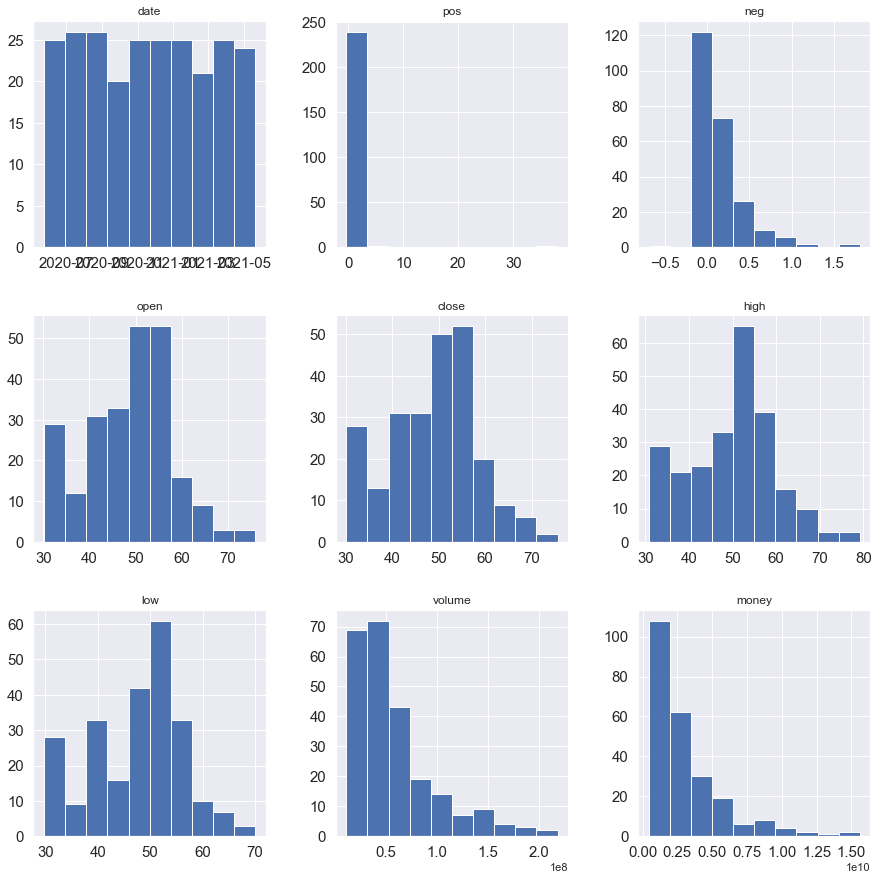

In [11]:
# 合成矩阵的每一特征的分布图
merged_data.hist(sharex = False, sharey = False, xlabelsize = 15, ylabelsize = 15, figsize=(15, 15))
plt.show()

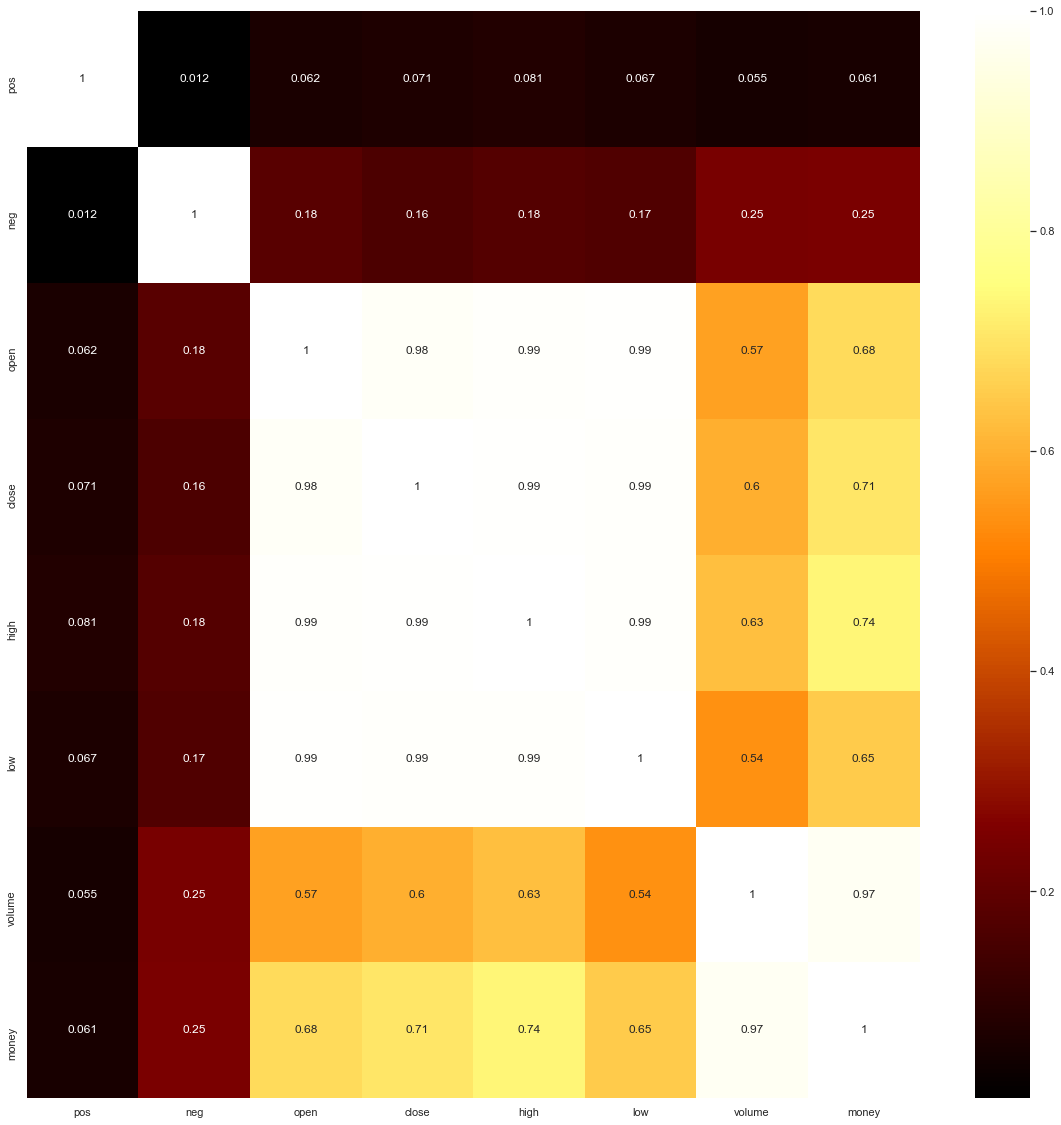

In [12]:
# 相似度矩阵
plt.figure(figsize=(20, 20))
sns.heatmap(merged_data.corr(), cmap=plt.cm.afmhot, annot=True)
plt.show()

## 3. Training:

#### the original stock price

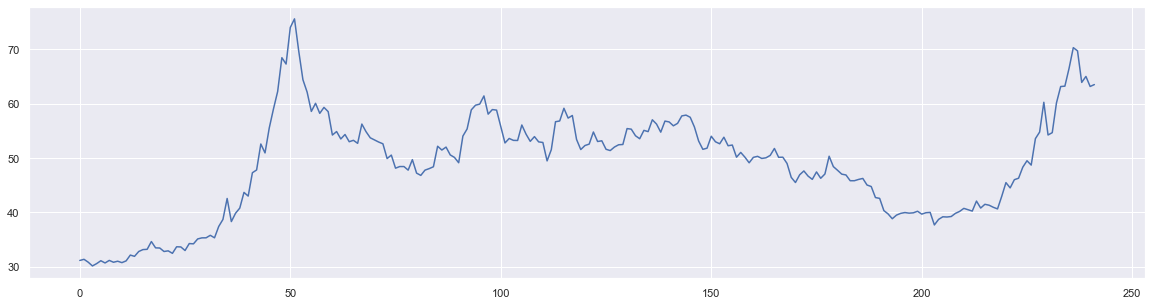

In [13]:
plt.figure(figsize=(20, 5))
plt.plot(merged_data["close"])

In [14]:
merged_data.head()

,date,pos,neg,open,close,high,low,volume,money
0,2020-05-25,0.451054,0.025495,30.91,31.12,31.52,30.78,20599861.0,6.412297e+08
1,2020-05-26,0.052651,0.193771,31.33,31.33,31.66,31.16,18963313.0,5.943644e+08
2,2020-05-27,0.239771,0.046422,31.37,30.80,31.47,30.37,27555024.0,8.486539e+08
3,2020-05-28,0.092130,0.100642,30.68,30.11,31.03,29.75,30655938.0,9.267066e+08
4,2020-05-29,0.094521,0.053147,30.15,30.54,30.74,30.12,23890232.0,7.284473e+08


In [15]:
data = merged_data.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(merged_data)), columns=['date', 'close'])
for i in range(0, len(data)):
    new_data["close"][i] = data["close"][i]
    new_data["date"][i] = data['date'][i]

news_part_data = pd.DataFrame(index=range(0,len(merged_data)),columns=['pos'])
for i in range(0, len(data)):
    news_part_data["pos"][i] = data['pos'][i]

news_part_data1 = pd.DataFrame(index=range(0,len(merged_data)),columns=['neg'])
for i in range(0, len(data)):
    news_part_data1["neg"][i] = data['neg'][i]

In [16]:
# 选择股票步长为3
stride = 3

next_data = new_data.values
# 选择前80%数据作为训练数据，后20%数据作为测试数据
len_train_data = len(next_data[0:int(len(next_data)*0.8), :])
len_valid_data = len(next_data[int(len(next_data)*0.8):, :])

new_data.index = new_data.date
new_data.drop("date", axis=1, inplace=True)
next_data = new_data.values

# for train data
minnmaxscaler = MinMaxScaler(feature_range=(0,1))
minnmaxscaler2 = MinMaxScaler(feature_range=(0,1))
minnmaxscaler3 = MinMaxScaler(feature_range=(0,1))
scaled = minnmaxscaler.fit_transform(next_data)
news_part = minnmaxscaler2.fit_transform(news_part_data.values)
news_part1 = minnmaxscaler3.fit_transform(news_part_data1.values)

# for test data
test_data = minnmaxscaler.transform(new_data[len_train_data - stride:].values.reshape(-1, 1))
test_news_data = minnmaxscaler2.transform(news_part_data[len_train_data - stride:].values.reshape(-1, 1))
test_news_data1 = minnmaxscaler2.transform(news_part_data1[len_train_data-stride:].values.reshape(-1, 1))


# build the train features with time lag: stride
x_train, y_train = [], []
for i in range(stride, len_train_data):
    x_part1 = scaled[i-stride:i,0]
    if news_method == 0:
        x_part2 = news_part[i-1:i,0]
        x_part3 = news_part1[i-1:i,0]
    elif news_method == 1:
        x_part2 = news_part[i:i+1,0]
        x_part3 = news_part1[i:i+1,0]
    elif news_method == 2:
        x_part2 = []
        x_part3 = []
    x_train.append(np.hstack((x_part3, x_part2, x_part1)))
    y_train.append(scaled[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))


# build the test features with time lag: stride
x_test = []
for i in range(stride, test_data.shape[0]):
    # add two: stride - stocks, news_stride - news
    x_part1 = test_data[i-stride:i,0]
    if news_method == 0:
        x_part2 = test_news_data[i-1:i,0]
        x_part3 = test_news_data1[i-1:i,0]
    elif news_method == 1:
        x_part2 = test_news_data[i:i+1,0]
        x_part3 = test_news_data1[i:i+1,0]
    elif news_method == 2:
        x_part2 = []
        x_part3 = []
    x_test.append(np.hstack((x_part3, x_part2, x_part1)))
    
x_test=np.array(x_test)
x_test=np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

#### LSTM model

In [17]:
# model
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

# compile
lstm_model.compile(loss='mean_squared_error',optimizer='adam')

# model summary
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3, 50)             10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


#### Train

In [18]:
# train
lstm_model.fit(x_train, y_train, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
190/190 - 2s - loss: 0.0187
Epoch 2/20
190/190 - 0s - loss: 0.0060
Epoch 3/20
190/190 - 0s - loss: 0.0050
Epoch 4/20
190/190 - 0s - loss: 0.0051
Epoch 5/20
190/190 - 0s - loss: 0.0048
Epoch 6/20
190/190 - 0s - loss: 0.0048
Epoch 7/20
190/190 - 0s - loss: 0.0044
Epoch 8/20
190/190 - 0s - loss: 0.0044
Epoch 9/20
190/190 - 0s - loss: 0.0038
Epoch 10/20
190/190 - 0s - loss: 0.0037
Epoch 11/20
190/190 - 0s - loss: 0.0039
Epoch 12/20
190/190 - 0s - loss: 0.0039
Epoch 13/20
190/190 - 0s - loss: 0.0041
Epoch 14/20
190/190 - 0s - loss: 0.0038
Epoch 15/20
190/190 - 0s - loss: 0.0032
Epoch 16/20
190/190 - 0s - loss: 0.0030
Epoch 17/20
190/190 - 0s - loss: 0.0033
Epoch 18/20
190/190 - 0s - loss: 0.0027
Epoch 19/20
190/190 - 0s - loss: 0.0026
Epoch 20/20
190/190 - 0s - loss: 0.0023


## 4. Testing:

#### Test

In [19]:
predicted_closing_price = lstm_model.predict(x_test)
predicted_closing_price = minnmaxscaler.inverse_transform(predicted_closing_price)

#### show result

In [20]:
train_data = new_data[:int(len(next_data)*0.8)]
valid_data = new_data[int(len(next_data)*0.8):]
valid_data['Predictions'] = predicted_closing_price
print(valid_data[['close', "Predictions"]])


gt_res = valid_data['close'].values.tolist()
pre_res = valid_data['Predictions'].values.tolist()

gt_trend, pre_trend = [], []
for i in range(1, len(gt_res)):
    if gt_res[i] > gt_res[i-1]:
        gt_trend.append(1)
    else:
        gt_trend.append(0)
        
    if pre_res[i] > pre_res[i-1]:
        pre_trend.append(1)
    else:
        pre_trend.append(0)

suqare_error = 0
for i in range(1, len(gt_res)):
    suqare_error += (gt_res[i] - pre_res[i])**2
suqare_error = suqare_error / (len(gt_res) - 1)
print(suqare_error)

            close  Predictions
date                          
2021-03-10   38.8    40.324883
2021-03-11  39.47    39.343403
2021-03-12  39.79    39.352524
2021-03-15  39.94    39.632534
2021-03-16  39.83    39.913155
2021-03-17  39.89    39.941509
2021-03-18  40.18    39.960094
2021-03-19  39.65    40.130497
2021-03-22  39.91    39.929176
2021-03-23  39.97    39.945065
2021-03-24  37.66    39.993118
2021-03-25  38.68    38.740562
2021-03-26  39.16    38.567818
2021-03-29  39.12    38.853981
2021-03-30  39.21    39.134445
2021-03-31  39.79    39.238182
2021-04-01  40.15    39.591141
2021-04-02  40.71    39.998005
2021-04-06  40.45    40.512806
2021-04-07  40.21    40.589569
2021-04-08  42.05    40.441246
2021-04-09  40.77    41.393097
2021-04-12  41.46    41.201553
2021-04-13  41.29    41.430382
2021-04-14  40.91    41.389133
2021-04-15  40.61    41.201694
2021-04-16  42.93    40.889053
2021-04-19  45.45    42.094398
2021-04-20  44.48    44.281681
2021-04-21  45.99    44.714424
2021-04-

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(array([18444., 18506., 18567., 18628., 18687., 18748.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

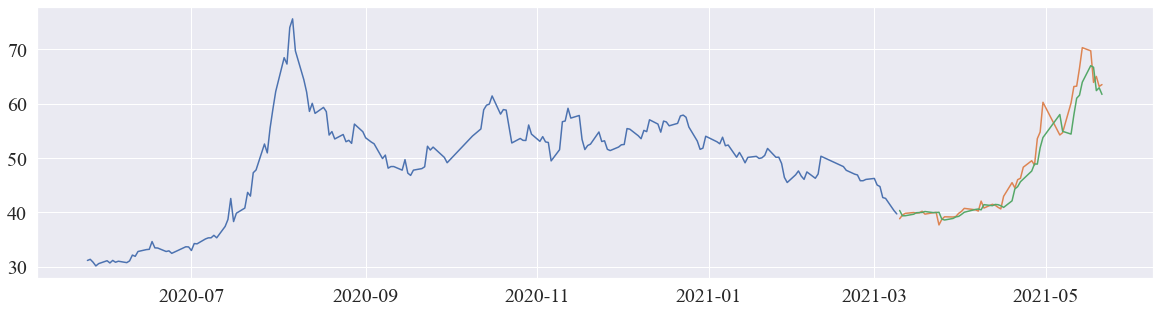

In [21]:
plt.figure(figsize=(20, 5))
plt.plot(train_data["close"])
plt.plot(valid_data[['close',"Predictions"]])
plt.yticks(fontproperties = 'Times New Roman', size = 20)
plt.xticks(fontproperties = 'Times New Roman', size = 20)

In [22]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(gt_trend, pre_trend)
print(acc)

0.4791666666666667
